**import libraries**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
import shutil
import cv2
import tensorflow as tf
import seaborn as sns
%matplotlib inline
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

**declare some variables**

In [2]:
split_ratio = 0.2
img_size = 224
inp_size = (224,224,3)
batch_size = 64
epoches = 20
lr = 1e-3

In [20]:
base_dir = os.path.dirname(os.path.abspath(sys.argv[1]))
base_dir

'E:\\sundar\\final_model'

In [20]:
label_data = pd.read_csv('train.csv')
all_img = os.listdir('F:\diabetic_reitinopathy_image/train_images')

**replace label '2' by '1', '3' by '2', and '4' by '2'**

In [21]:
label_data['diagnosis'].replace({2:1, 3:2, 4:2}, inplace=True)

In [22]:
label_data

,id_code,diagnosis
0,000c1434d8d7,1
1,001639a390f0,2
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,1
3658,ffc04fed30e6,0
3659,ffcf7b45f213,1
3660,ffd97f8cd5aa,0


**check label**

In [23]:
set(label_data['diagnosis'])

{0, 1, 2}

**count total number of image on each label**

In [24]:
label_data['diagnosis'].value_counts()

0    1805
1    1369
2     488
Name: diagnosis, dtype: int64

**graph after spliting data**

In [9]:
def image_category():
    '''
    INPUT
      label_data : label data
    OUTPUT
      Count total label in each category
    '''
    total_category_level = label_data['diagnosis'].value_counts()
    return total_category_level

In [10]:
image_category()

0    1805
1    1369
2     488
Name: diagnosis, dtype: int64

In [11]:
def plot_graph(category):
    label = ['NO DR', 'Moderate', 'Severe']
    #   c = ['orange', 'blue','red','green','purple']
    label_category = list(category)
    plt.bar(label, label_category, alpha=0.8, width = 0.4)
    plt.savefig("label_after_split.png")
    plt.show()

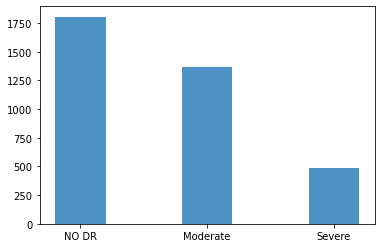

In [12]:
plot_graph(image_category())

**create folder**

In [13]:
if os.path.isdir('seperate_img') is False:
    os.makedirs('seperate_img')

**copy label 2 images into seperate_img folder**

In [14]:
%%time
for i, (idx, row) in enumerate(label_data.loc[label_data['diagnosis'] == 2].iterrows()):
        path = os.path.join(base_dir, f"F:\diabetic_reitinopathy_image/train_images/{row['id_code']}.png")
        shutil.copy(path, os.path.join(base_dir, 'seperate_img'))

Wall time: 1min 24s


### image augmentation###

In [15]:
if os.path.isdir('augement_img') is False:
    os.makedirs('augement_img')

In [16]:
%%time
for img in os.listdir(os.path.join(base_dir, 'seperate_img')):
    img_split = img.split('.')
    image = cv2.imread(os.path.join(base_dir, f"seperate_img/{img}"))
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    
    # rotate image 
    M = cv2.getRotationMatrix2D((cX, cY), 180, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h)) 
    v_flip = cv2.flip(image, 0)
    
    cv2.imwrite(os.path.join(base_dir, f"augement_img/{img_split[0]}_rotated.png"), rotated)
    cv2.imwrite(os.path.join(base_dir, f"augement_img/{img_split[0]}_flip.png"), v_flip)

Wall time: 6min 15s


In [17]:
augment_img = os.listdir('augement_img')
len(augment_img)

976

**before data augmentation**

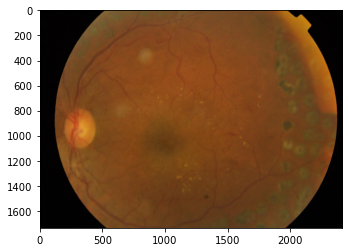

In [18]:
path = os.path.join(base_dir, f"F:\diabetic_reitinopathy_image/train_images/f0098e9d4aee.png")
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

**after data augmentation**

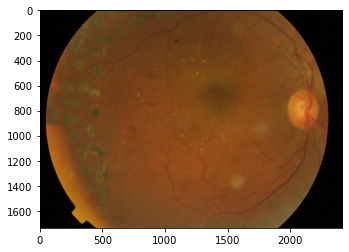

In [19]:
path = os.path.join(base_dir, f"F:\diabetic_reitinopathy_image/train_images/f0098e9d4aee.png")
image = cv2.imread(path) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# grab the dimensions of the image and calculate the center of the
# image
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2)

# rotate image
M = cv2.getRotationMatrix2D((cX, cY), 180, 1.0)

rotated = cv2.warpAffine(image, M, (w, h))

cv2.imshow("Rotated by 45 Degrees", rotated)
plt.imshow(rotated)

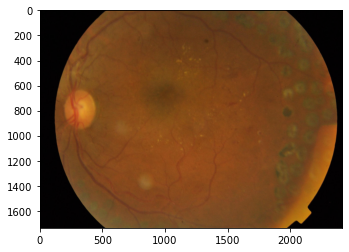

In [20]:
path = os.path.join(base_dir, f"F:\diabetic_reitinopathy_image/train_images/f0098e9d4aee.png")
image = cv2.imread(path) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# grab the dimensions of the image and calculate the center of the
# image
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2)

# rotate image
M = cv2.getRotationMatrix2D((cX, cY), 180, 1.0)
flip = cv2.flip(image, 0)

cv2.imshow("Rotated by 45 Degrees", flip)
plt.imshow(flip)

**create sepearte csv file of augmented images**

In [21]:
my_dict = {
    "id_code":[],
    "diagnosis":[]
};

for img in os.listdir(os.path.join(base_dir, 'augement_img')):
    img_name = img.split('.')[0]
    # image name as id_code
    my_dict['id_code'].append(img_name) 
    #set label 2 to each of the images
    my_dict['diagnosis'].append(2) 

In [22]:
df = pd.DataFrame(my_dict)
df.to_csv('augment.csv',index=False)

In [23]:
df

,id_code,diagnosis
0,001639a390f0_flip,2
1,001639a390f0_rotated,2
2,0083ee8054ee_flip,2
3,0083ee8054ee_rotated,2
4,0104b032c141_flip,2
...,...,...
971,fdd534271f3d_rotated,2
972,fe0fc67c7980_flip,2
973,fe0fc67c7980_rotated,2
974,ff8a0b45c789_flip,2


**merge two csv files**

In [24]:
new_label = label_data.append(df, ignore_index=False)
new_label.to_csv('new_label.csv', index=False)

In [25]:
new_label

,id_code,diagnosis
0,000c1434d8d7,1
1,001639a390f0,2
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
971,fdd534271f3d_rotated,2
972,fe0fc67c7980_flip,2
973,fe0fc67c7980_rotated,2
974,ff8a0b45c789_flip,2


**copy augmented images in main image dir**

In [108]:
augment_img = os.listdir('augement_img')
len(augment_img)

976

In [97]:
%%time
for img in augment_img:
    shutil.copy(os.path.join("augement_img", img),"F:\diabetic_reitinopathy_image/train_images")

Wall time: 3min 48s


In [98]:
all_augment_img = os.listdir('F:\diabetic_reitinopathy_image/train_images')
len(all_augment_img)

4638

In [26]:
updated_label_data = pd.read_csv('new_label.csv')
updated_label_data

,id_code,diagnosis
0,000c1434d8d7,1
1,001639a390f0,2
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
4633,fdd534271f3d_rotated,2
4634,fe0fc67c7980_flip,2
4635,fe0fc67c7980_rotated,2
4636,ff8a0b45c789_flip,2


**check new data update**

In [15]:
new_label_data = pd.read_csv('new_label.csv')

In [16]:
new_label_data['diagnosis'].value_counts()

0    1805
2    1464
1    1369
Name: diagnosis, dtype: int64

**new grpah plot**

In [29]:
def image_category():
    '''
    INPUT
      label_data : label data
    OUTPUT
      Count total label in each category
    '''
    total_category_level = new_label_data['diagnosis'].value_counts()
    return total_category_level

In [30]:
image_category()

0    1805
2    1464
1    1369
Name: diagnosis, dtype: int64

In [31]:
def plot_graph(category):
    label = ['NO DR', 'Moderate', 'Severe']
    #   c = ['orange', 'blue','red','green','purple']
    label_category = list(category)
    plt.bar(label, label_category, alpha=0.8, width = 0.4)
    plt.savefig("new_label.png")
    plt.show()

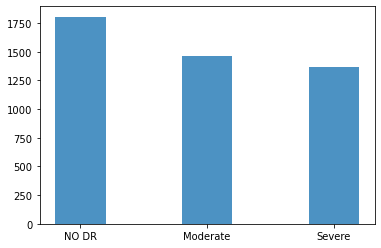

In [32]:
plot_graph(image_category())

### image processing ###

In [17]:
eye_label = new_label_data['diagnosis'].unique()
eye_label

array([1, 2, 0], dtype=int64)

In [18]:
new_label_data

,id_code,diagnosis
0,000c1434d8d7,1
1,001639a390f0,2
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
4633,fdd534271f3d_rotated,2
4634,fe0fc67c7980_flip,2
4635,fe0fc67c7980_rotated,2
4636,ff8a0b45c789_flip,2


**crop image**

In [6]:
def crop_image_from_gray(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

**color change**

In [7]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (img_size, img_size))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

**processing**

In [21]:
%%time
data = []
labels=[]
for class_id in sorted([0,1,2]):
    for i, (idx, row) in enumerate(new_label_data.loc[new_label_data['diagnosis'] == class_id].iterrows()):
        if row['id_code'] != '':
            path  = os.path.join(f"F:\diabetic_reitinopathy_image/train_images/{row['id_code']}.png")
            image = load_ben_color(path,sigmaX=30)
            image = image/255.0
            image = np.array(image)
            data.append(image)
            labels.append(row['diagnosis'])

Wall time: 28min 17s


**conver into numpy**

In [22]:
%%time
im_image = np.array(data)
im_label = np.array(labels)

Wall time: 1min 24s


In [23]:
#shape of array
print("Dimension of image array  : ",im_image.ndim)
print("Shape of image array : ", im_image.shape)
print("Dimension of label  : ",im_label.ndim)
print("Shape of label : ",im_label.shape)

Dimension of image array  :  4
Shape of image array :  (4638, 224, 224, 3)
Dimension of label  :  1
Shape of label :  (4638,)


**save data**

In [24]:
%%time
np.save('image_data.npy', im_image)

Wall time: 1min 17s
Compiler : 180 ms
Parser   : 232 ms


In [25]:
%%time
np.save('label_data.npy', im_label)

Wall time: 153 ms
